#Import Libraries

In [1]:
import zipfile
import glob
import os.path
from os import path
import cv2
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

#Download Dataset if not unavailable

In [2]:
if not path.exists("intel-image-classification.zip"):
  !gdown https://drive.google.com/uc?id=1a2zXwkvQaIJLDzUud2WCRNdpQChL0w0K

if not path.exists("dataset"):
  with zipfile.ZipFile('/content/intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/')

Downloading...
From: https://drive.google.com/uc?id=1a2zXwkvQaIJLDzUud2WCRNdpQChL0w0K
To: /content/intel-image-classification.zip
362MB [00:07, 51.1MB/s]


#Load Model 

In [3]:
model = VGG16(include_top=False, input_shape=(150, 150, 3))
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(6, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)

58892288/58889256 [==============================] - 1s 0us/step


In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

##Freeze model layers for transfer learning

In [5]:
for i, layer in enumerate(model.layers):
   layer.trainable = False
   if i==15:
     break

##Model summary after freezing the initial layers

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#Load Dataset

##Using Data generator because of large dataset

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

pred_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_path = "./dataset/seg_train/"
test_data_path = "./dataset/seg_test/"
pred_data_path = "./dataset/seg_pred/"

In [9]:
train_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=(150, 150),
        batch_size=32,
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(150, 150),
        batch_size=32,
        shuffle=False)

pred_generator = pred_datagen.flow_from_directory(
        pred_data_path,
        target_size=(150, 150),
        batch_size=32,
        shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


#Compile the model

In [10]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#Train the Model

In [11]:
H = model.fit(train_generator, batch_size=128, epochs=20, validation_data=test_generator)

Epoch 1/20
439/439 [==============================] - 131s 280ms/step - loss: 0.7089 - accuracy: 0.7297 - val_loss: 0.3068 - val_accuracy: 0.8913
Epoch 2/20
439/439 [==============================] - 120s 273ms/step - loss: 0.3156 - accuracy: 0.8863 - val_loss: 0.2908 - val_accuracy: 0.8900
Epoch 3/20
439/439 [==============================] - 119s 271ms/step - loss: 0.2702 - accuracy: 0.9041 - val_loss: 0.2975 - val_accuracy: 0.8943
Epoch 4/20
439/439 [==============================] - 119s 272ms/step - loss: 0.2367 - accuracy: 0.9135 - val_loss: 0.2605 - val_accuracy: 0.9117
Epoch 5/20
439/439 [==============================] - 119s 271ms/step - loss: 0.2279 - accuracy: 0.9216 - val_loss: 0.2540 - val_accuracy: 0.9110
Epoch 6/20
439/439 [==============================] - 119s 272ms/step - loss: 0.1927 - accuracy: 0.9294 - val_loss: 0.2439 - val_accuracy: 0.9113
Epoch 7/20
439/439 [==============================] - 120s 273ms/step - loss: 0.1835 - accuracy: 0.9361 - val_loss: 0.2672 -

#Display Loss and accoracy metrics

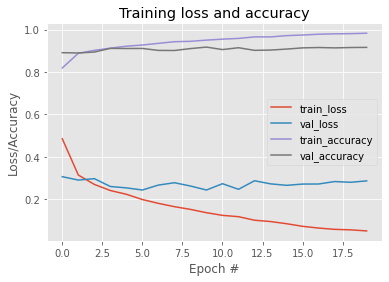

In [15]:
import matplotlib.pyplot as plt
N = np.arange(0, 20)
plt.style.use('ggplot')
plt.figure()
plt.plot(np.array(N), np.array(H.history['loss']), label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [22]:
plt.savefig('Model statistics.png')

<Figure size 432x288 with 0 Axes>

#Saving the weights

In [17]:
model.save_weights('vgg_trasfer_learning_weights.h5')

#Check Test Accuracy

In [13]:
score = model.evaluate(pred_generator, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

229/229 [==============================] - 32s 140ms/step - loss: 0.3048 - accuracy: 0.9143
Test Loss =  0.30481719970703125
Test Accuracy =  0.9142583012580872


#Confusion Matrix

In [18]:
y_pred = model.predict(pred_generator)
y_true = pred_generator.classes

In [19]:
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=-1))

In [20]:
confusion_mtx

array([[1074,    2,    0,    1,    5,   62],
       [   3, 1149,    2,    3,    3,    6],
       [   3,    4, 1135,  140,   45,    3],
       [   4,    5,  107, 1102,   74,    5],
       [   5,    4,   25,   33, 1051,   10],
       [  61,    3,    4,    1,    3, 1164]])